In [23]:
import sys
sys.path.append('eval/')
sys.path.append('models/')
sys.path.append('process_data/')

import glob
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
%matplotlib inline
import numpy as np
import pandas as pd
import pickle as pkl
import torch
from scipy.stats import poisson, norm, laplace, lognorm

from class_mve_loss import MVELoss

import util_eval
import util_gcnn
import util_plot
import util_results

from util_data import dotdict

from default_parameters import *
from setup import * 

%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 9})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyperparameters

In [3]:
project_dir = "/home/jtl/Dropbox (MIT)/project_uncertainty_quantification/"

args = dotdict({"Period": 'before',
       "Model":"GCN",
       "OutFolder":"220405",
       "Lookback":4,
       "Dist":"norm",
       "MeanOnly":False,
       "ModelNumberStart":-1,
       "ModelNumberEnd":0,
       "Adj":["func","euc","con","net"],
       "Save":False,
       "PredictHorizon":1,
       "TimeSize":4,
       "Difference":True,
       "LossFunc":"mve",
       "Homoskedastic":False,
       "TrainExtent":"downtown",
       "Epoch":501,
       "LearningRate":0.001,
       "IncludeSpatial":False,
       "Bootstrap":False})

dropout_rate_list=[0.2,0.5]
n_hid_units_list=[64,128]
weight_decay_list = [0.0001, 0.001, 0.01, 0.1]
ngc_list = [1,2]
nlstm_list = [1,2]
hps = list(itertools.product(dropout_rate_list, n_hid_units_list, weight_decay_list, nlstm_list, ngc_list))
max_lookback = 6


if args.ModelNumberStart == -1:
    run_all = True
else:
    run_all = False

predict_hzn = args.PredictHorizon
time_size = args.TimeSize
difference = args.Difference
adj_type = args.Adj
train_extent = args.TrainExtent
out_folder = args.OutFolder

downtown_stations = pd.read_csv(project_dir+"data/data_processed/downtown_stations.csv")
criterion = MVELoss(dist=args.Dist)
device = torch.device("cpu")

z=1.96

# Before

## Get Ensembled Results

In [314]:
b_ensemble_model_numbers = [21,17,18,25,3]

period = "before"
lookback = 4
adj_type = ["func","euc","con","net"]

if args.Model == 'GCN':
    save_dir = project_dir+"models/"+args.OutFolder+"_"+period+"_"+args.Dist+"/"
else:
    save_dir = project_dir+"models/"+args.OutFolder+"_"+period+"_"+args.Model+"_"+args.Dist+"/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)

In [315]:
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, period, predict_hzn, time_size, difference, max_lookback, lookback)

In [318]:
b_ts_test, b_y_test_eval, b_test_ens_mean, b_test_ens_std, b_ens_mean_list, b_ens_std_list = \
    util_gcnn.ensemble(project_dir, save_dir, period, predict_hzn, time_size, lookback, 
                       b_ensemble_model_numbers, device, train_extent, adj_type,
                       data, adj, spatial, downtown_filter,)
b_test_mean = np.mean(b_y_test_eval)


In [319]:
test_out_predict, test_out_std = util_eval.post_process_dist(args.Dist, b_test_ens_mean, b_test_ens_std)
b_test_mae, b_test_mse, _, _, _ = util_eval.eval_mean(b_test_ens_mean, b_y_test_eval, "")
lb, ub = util_eval.post_process_pi(args.Dist, b_test_ens_mean, b_test_ens_std, z=0.95)
b_mpiw, b_picp = util_eval.eval_pi(lb, ub, b_y_test_eval)

In [320]:
b_test_loss = -np.sum(norm.logpdf(b_y_test_eval, b_test_ens_mean, b_test_ens_std))/len(b_y_test_eval)

In [321]:
b_num_points = len(b_y_test_eval.flatten())
b_p_gcn = []

p = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999])
for i in p:
    b_p_gcn.append(np.sum(b_y_test_eval <= norm.ppf(i, loc=b_test_ens_mean, scale=b_test_ens_std))/b_num_points)
b_cal_error = np.sum(np.abs(b_p_gcn-p) * interval)

In [322]:
print("Gaussian Ensemble Results:")
print("{:.2f} & {:.3f} & {:.2f} & {:.1%} & {:.1f} & {:.1%} \\\\".format(b_test_loss, b_cal_error, b_mpiw, b_picp, b_test_mae, b_test_mae/b_test_mean))


Gaussian Ensemble Results:
94.11 & 0.034 & 396.95 & 96.2% & 66.4 & 10.5% \\


## Model Uncertainty vs. Data Uncertainty

In [106]:
ratio = b_test_ens_std / b_test_ens_mean

In [107]:
max_station = np.argmax(np.mean(data['y'][1][:,:,downtown_filter], axis=0))
min_station = np.argmin(np.mean(data['y'][1][:,:,downtown_filter], axis=0))

print('Station with max flow:')
print(downtown_stations[downtown_stations['STATION_ID']==data['stations'][max_station]][['STATION_ID','LONGNAME', 'LINES']].iloc[0].to_numpy())

print('Station with min flow:')
print(downtown_stations[downtown_stations['STATION_ID']==data['stations'][min_station]][['STATION_ID','LONGNAME', 'LINES']].iloc[0].to_numpy())


Station with max flow:
[260 'State/Lake' 'Brown, Orange, Pink,  Purple (Express), Green']
Station with min flow:
[160 'LaSalle/Van Buren' 'Brown, Orange, Pink, Purple (Express)']


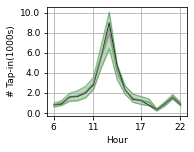

In [127]:
ub = np.amax(np.array([i[:, max_station] for i in b_ens_mean_list]), axis=0)
lb = np.amin(np.array([i[:, max_station] for i in b_ens_mean_list]), axis=0)

plot_scale = 1000
fig, ax = util_plot.plot_time_series(b_ts_test, [[b_y_test_eval[:,max_station]/plot_scale]], duration=1,
                                 label1=['# Tap-in(1000s)'], label2=['Actual'],
                                 colors=['black'])

_, ax = util_plot.plot_pi_by_bounds(ax[0], 'Data Uncertainty', b_ts_test, 
                                 np.maximum(b_test_ens_mean-z*b_test_ens_std,0)[:, max_station]/plot_scale, 
                                 (b_test_ens_mean+z*b_test_ens_std)[:, max_station]/plot_scale, time_size, duration=1,
                                 c='forestgreen')
_, ax = util_plot.plot_pi_by_bounds(ax, 'Model Uncertainty', b_ts_test, 
                                 lb/plot_scale, ub/plot_scale, time_size, duration=1,
                                 c='grey')
ax.grid(True)
y_fmt = tick.FormatStrFormatter('%1.1f')
ax.yaxis.set_major_formatter(y_fmt)
fig[0].savefig(project_dir+"figures/"+out_folder+"/before_model_data_unc_max.png", bbox_inches='tight')


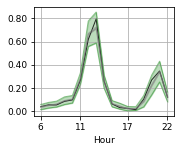

In [129]:
ub = np.amax(np.array([i[:, min_station] for i in b_ens_mean_list]), axis=0)
lb = np.amin(np.array([i[:, min_station] for i in b_ens_mean_list]), axis=0)

fig, ax = util_plot.plot_time_series(b_ts_test, [[b_y_test_eval[:,min_station]/plot_scale]], duration=1, 
                                 label1=[''], label2=['Actual'],
                                 colors=['black'])

_, ax = util_plot.plot_pi_by_bounds(ax[0], 'Data Uncertainty', b_ts_test, 
                                 np.maximum(b_test_ens_mean-z*b_test_ens_std,0)[:, min_station]/plot_scale, 
                                 (b_test_ens_mean+z*b_test_ens_std)[:, min_station]/plot_scale, time_size, duration=1,
                                 c='forestgreen')
_, ax = util_plot.plot_pi_by_bounds(ax, 'Model Uncertainty', b_ts_test, 
                                 lb/plot_scale, ub/plot_scale, time_size, duration=1,
                                 c='grey')
# ax.legend(bbox_to_anchor=(1.2,1))
ax.grid(True)
y_fmt = tick.FormatStrFormatter('%0.2f')
ax.yaxis.set_major_formatter(y_fmt)
fig[0].savefig(project_dir+"figures/"+out_folder+"/before_model_data_unc_min.png", bbox_inches='tight')


## Plot PI

Plotting cell with max flow:  (5,)


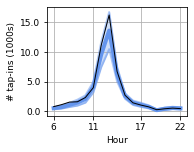

In [133]:
fig, ax = util_plot.plot_pi_graph(ts_test=b_ts_test, y_test=b_y_test_eval/plot_scale, 
                        pred_test=[b_test_ens_mean/plot_scale], 
                        pred_std=[b_test_ens_std/plot_scale],
                        z=z, time_size=time_size, 
                        models=['GCN Ensemble'],
                        duration=1)
y_fmt = tick.FormatStrFormatter('%0.1f')
ax.yaxis.set_major_formatter(y_fmt)
ax.set_ylabel("# tap-ins (1000s)");
# fig.savefig(project_dir+"figures/"+out_folder+"/"+period+"_ens_pi_max_temp.png", bbox_inches='tight')

Plotting cell with min flow:  (15,)


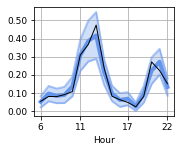

In [134]:
fig, ax = util_plot.plot_pi_graph(ts_test=b_ts_test, y_test=b_y_test_eval/plot_scale, 
                              pred_test=[b_test_ens_mean/plot_scale], 
                              pred_std=[b_test_ens_std/plot_scale],
                              z=z, time_size=time_size, 
                              models=['GCN Ensemble'],
                              plot_cell=-1)
# ax.legend(bbox_to_anchor=(1.2,1))
y_fmt = tick.FormatStrFormatter('%0.2f')
ax.yaxis.set_major_formatter(y_fmt);
# fig.savefig(project_dir+"figures/"+out_folder+"/"+period+"_ens_pi_min_temp.png", bbox_inches='tight')

# After

## Get Ensembled Results

In [305]:
if args.Model == 'GCN':
    save_dir = project_dir+"models/"+args.OutFolder+"_"+period+"_"+args.Dist+"/"
else:
    save_dir = project_dir+"models/"+args.OutFolder+"_"+period+"_"+args.Model+"_"+args.Dist+"/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)

In [306]:
period = "after"
lookback = 4
adj_type = ["func","euc","con","net"]
a_ensemble_model_numbers = [17,29,25,54,18]

data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, period, predict_hzn, time_size, difference, max_lookback, lookback)

In [307]:
a_ts_test, a_y_test_eval, a_test_ens_mean, a_test_ens_std, a_ens_mean_list, a_ens_std_list = \
    util_gcnn.ensemble(project_dir, save_dir, period, predict_hzn, time_size, lookback, 
                       a_ensemble_model_numbers, device, train_extent, adj_type,
                       data, adj, spatial, downtown_filter)
a_test_mean = np.mean(a_y_test_eval)


In [309]:
test_out_predict, test_out_std = util_eval.post_process_dist(args.Dist, a_test_ens_mean, a_test_ens_std)
a_test_mae, a_test_mse, _, _, _ = util_eval.eval_mean(a_test_ens_mean, a_y_test_eval, "")
lb, ub = util_eval.post_process_pi(args.Dist, a_test_ens_mean, a_test_ens_std, z=0.95)
a_mpiw, a_picp = util_eval.eval_pi(lb, ub, a_y_test_eval)

In [310]:
a_test_loss = -np.sum(norm.logpdf(a_y_test_eval, a_test_ens_mean, a_test_ens_std))/len(a_y_test_eval)

In [311]:
a_num_points = len(a_y_test_eval.flatten())
a_p_gcn = []

p = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999])
for i in p:
    a_p_gcn.append(np.sum(a_y_test_eval <= norm.ppf(i, loc=a_test_ens_mean, scale=a_test_ens_std))/a_num_points)
a_cal_error = np.sum(np.abs(a_p_gcn-p) * interval)

In [312]:
print("Gaussian Ensemble Results:")
print("{:.2f} & {:.3f} & {:.2f} & {:.1%} & {:.1f} & {:.1%} \\\\".format(a_test_loss, a_cal_error, a_mpiw, a_picp, a_test_mae, a_test_mae/a_test_mean))


Gaussian Ensemble Results:
70.83 & 0.026 & 73.04 & 95.8% & 13.5 & 15.2% \\


## Model Uncertainty vs. Data Uncertainty

In [114]:
max_station = np.argmax(np.mean(data['y'][1][:,:,downtown_filter], axis=0))
min_station = np.argmin(np.mean(data['y'][1][:,:,downtown_filter], axis=0))

print('Station with max flow:')
print(downtown_stations[downtown_stations['STATION_ID']==data['stations'][max_station]][['STATION_ID','LONGNAME', 'LINES']].iloc[0].to_numpy())

print('Station with min flow:')
print(downtown_stations[downtown_stations['STATION_ID']==data['stations'][min_station]][['STATION_ID','LONGNAME', 'LINES']].iloc[0].to_numpy())


Station with max flow:
[260 'State/Lake' 'Brown, Orange, Pink,  Purple (Express), Green']
Station with min flow:
[160 'LaSalle/Van Buren' 'Brown, Orange, Pink, Purple (Express)']


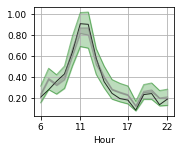

In [126]:
ub = np.amax(np.array([i[:, max_station] for i in a_ens_mean_list]), axis=0)
lb = np.amin(np.array([i[:, max_station] for i in a_ens_mean_list]), axis=0)

fig, ax = util_plot.plot_time_series(a_ts_test, [[a_y_test_eval[:,max_station]/plot_scale]], 
                                 label1=[""], label2=['Actual'],
                                 colors=['black'])

_, ax = util_plot.plot_pi_by_bounds(ax[0], 'Data Uncertainty', a_ts_test, 
                                 np.maximum(a_test_ens_mean-z*a_test_ens_std,0)[:, max_station]/plot_scale, 
                                 (a_test_ens_mean+z*a_test_ens_std)[:, max_station]/plot_scale, time_size,
                                 c='forestgreen')
_, ax = util_plot.plot_pi_by_bounds(ax, 'Model Uncertainty', a_ts_test, 
                                 lb/plot_scale, ub/plot_scale, time_size,
                                 c='grey')
ax.grid(True)
y_fmt = tick.FormatStrFormatter('%0.2f')
ax.yaxis.set_major_formatter(y_fmt)
fig[0].savefig(project_dir+"figures/"+out_folder+"/"+period+"_model_data_unc_max.png", bbox_inches='tight')


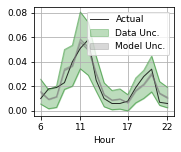

In [125]:
ub = np.amax(np.array([i[:, min_station] for i in a_ens_mean_list]), axis=0)
lb = np.amin(np.array([i[:, min_station] for i in a_ens_mean_list]), axis=0)

fig, ax = util_plot.plot_time_series(a_ts_test, [[a_y_test_eval[:,min_station]/plot_scale]], 
                                 label1=[''], label2=['Actual'],
                                 colors=['black'])

_, ax = util_plot.plot_pi_by_bounds(ax[0], 'Data Unc.', a_ts_test, 
                                 np.maximum(a_test_ens_mean-z*a_test_ens_std,0)[:, min_station]/plot_scale, 
                                 (a_test_ens_mean+z*a_test_ens_std)[:, min_station]/plot_scale, time_size,
                                 c='forestgreen')
_, ax = util_plot.plot_pi_by_bounds(ax, 'Model Unc.', a_ts_test, 
                                 lb/plot_scale, ub/plot_scale, time_size,
                                 c='grey')

ax.grid(True)
ax.legend()
y_fmt = tick.FormatStrFormatter('%0.2f')
ax.yaxis.set_major_formatter(y_fmt)
fig[0].savefig(project_dir+"figures/"+out_folder+"/"+period+"_model_data_unc_min.png", bbox_inches='tight')


## Plot PI

Plotting cell with max flow:  (5,)


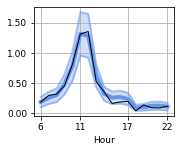

In [135]:
fig, ax = util_plot.plot_pi_graph(ts_test=a_ts_test, y_test=a_y_test_eval/plot_scale, 
                              pred_test=[a_test_ens_mean/plot_scale], 
                              pred_std=[a_test_ens_std/plot_scale],
                        z=z, time_size=time_size, models=['GCN Ensemble'])
y_fmt = tick.FormatStrFormatter('%0.2f')
ax.yaxis.set_major_formatter(y_fmt);
# fig.savefig(project_dir+"figures/"+out_folder+"/"+period+"_ens_pi_max_temp.png", bbox_inches='tight')

Plotting cell with min flow:  (2,)


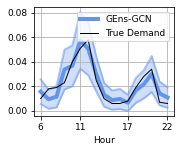

In [139]:
fig, ax = util_plot.plot_pi_graph(ts_test=a_ts_test, y_test=a_y_test_eval/plot_scale, 
                              pred_test=[a_test_ens_mean/plot_scale], 
                              pred_std=[a_test_ens_std/plot_scale],
                              z=z, time_size=time_size, models=['GEns-GCN'],
                             plot_cell=-1)
ax.legend();
# fig.savefig(project_dir+"figures/"+out_folder+"/"+period+"_ens_pi_min_temp.png", bbox_inches='tight')

# Combined

## GCN Results

In [201]:
df = pd.read_csv(project_dir+"results/"+out_folder+"rail_catchment_mve_results_val.csv")
df['val_rmse'] = np.sqrt(df['val_mse'])
df['test_rmse'] = np.sqrt(df['test_mse'])

In [202]:
# Drop duplicate Runs
df = df.drop_duplicates(subset=['Model Type', 'Period', 'Train Extent','Extent','Adjacency','Model','Predict Horizon',
                               'Time Size','Lookback'], keep='last')
# Refresh
df.to_csv(project_dir+"results/rail_catchment_mve_results_val.csv", index=False)

In [203]:
before = df[df['Period'] == 'before']
before=before[before['test_nll_loss']<np.percentile(before['test_nll_loss'], 58)]
before=before[before['Adjacency'] == 'func_euc_con_net']
before=before[before['Lookback'] == 2]

In [204]:
after=df[df['Period'] == 'after']
after=after[after['test_nll_loss']<np.percentile(after['test_nll_loss'], 58)]
after=after[after['Adjacency'] == 'func_euc_con_net']
after=after[after['Lookback'] == 2]

In [221]:
before['test_mape'] = before['test_mae'] / np.mean(b_y_test_eval)
after['test_mape'] = after['test_mae'] / np.mean(a_y_test_eval)

## Spatial Temporal Uncertainty

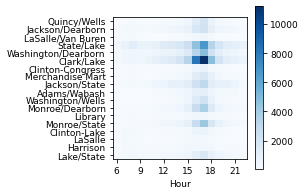

In [323]:
b_mean = pd.DataFrame(b_test_ens_mean[5:], index=b_ts_test[5:], columns = data['stations'])
b_mean['hour'] = b_mean.index % 24

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(b_mean.groupby('hour').mean().to_numpy().T, cmap = 'Blues')
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
ax.set_yticks(np.arange(len(data['stations'])))
ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.set_xlabel("Hour");
plt.colorbar();
fig.savefig(project_dir+"figures/"+out_folder+"/before_stmean.png", bbox_inches='tight');


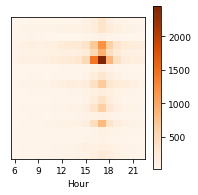

In [329]:
b_std = pd.DataFrame(b_test_ens_std[5:], index=b_ts_test[5:], columns = data['stations'])
b_std['hour'] = b_std.index % 24

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(b_std.groupby('hour').mean().to_numpy().T, cmap = 'Oranges')
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
# ax.set_yticks(np.arange(len(data['stations'])))
# ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.get_yaxis().set_visible(False)
ax.set_xlabel("Hour");
plt.colorbar();
fig.savefig(project_dir+"figures/"+out_folder+"/before_ststd.png", bbox_inches='tight');


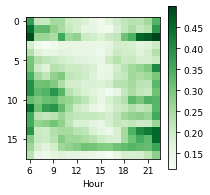

In [330]:
b_std = pd.DataFrame(b_test_ens_std[5:]/b_test_ens_mean[5:], index=b_ts_test[5:], columns = data['stations'])
b_std['hour'] = b_std.index % 24

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(b_std.groupby('hour').mean().to_numpy().T, cmap = 'Greens')
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
# ax.set_yticks(np.arange(len(data['stations'])))
# ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.set_xlabel("Hour");
plt.colorbar();
fig.savefig(project_dir+"figures/"+out_folder+"/before_stunc_pct.png", bbox_inches='tight');


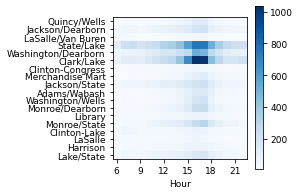

In [332]:
a_mean = pd.DataFrame(a_test_ens_mean[5:], index=a_ts_test[5:], columns = data['stations'])
a_mean['hour'] = a_mean.index % 24

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(a_mean.groupby('hour').mean().to_numpy().T, cmap = 'Blues')
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
ax.set_yticks(np.arange(len(data['stations'])))
ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.set_xlabel("Hour");
plt.colorbar();
fig.savefig(project_dir+"figures/"+out_folder+"/after_stmean.png", bbox_inches='tight');


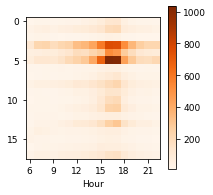

In [333]:
a_std = pd.DataFrame(a_test_ens_mean[5:], index=a_ts_test[5:], columns = data['stations'])
a_std['hour'] = a_std.index % 24

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(a_std.groupby('hour').mean().to_numpy().T, cmap = 'Oranges')
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
# ax.set_yticks(np.arange(len(data['stations'])))
# ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.set_xlabel("Hour");
plt.colorbar();
fig.savefig(project_dir+"figures/"+out_folder+"/after_ststd.png", bbox_inches='tight');


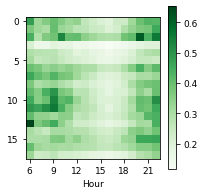

In [334]:
a_std = pd.DataFrame(a_test_ens_std[5:]/a_test_ens_mean[5:], index=a_ts_test[5:], columns = data['stations'])
a_std['hour'] = a_std.index % 24

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(a_std.groupby('hour').mean().to_numpy().T, cmap = 'Greens')
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
# ax.set_yticks(np.arange(len(data['stations'])))
# ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.set_xlabel("Hour");
plt.colorbar();
fig.savefig(project_dir+"figures/"+out_folder+"/after_stunc_pct.png", bbox_inches='tight');


## Spatial Temporal Residuals

In [336]:
b_test_ens_residuals = b_y_test_eval - b_test_ens_mean
b_test_ens_outlier = np.abs(b_test_ens_residuals) > (b_test_ens_std * 1.96)
b_stu = pd.DataFrame(b_test_ens_outlier[5:], index=b_ts_test[5:], columns = data['stations'])
b_stu['hour'] = b_stu.index % 24

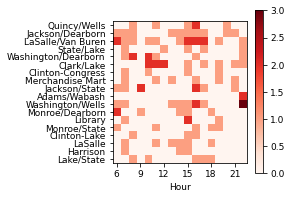

In [337]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(b_stu.groupby('hour').sum().to_numpy().T, cmap = 'Reds')
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
ax.set_yticks(np.arange(len(data['stations'])))
ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.set_xlabel("Hour");
plt.colorbar()
fig.savefig(project_dir+"figures/"+out_folder+"/before_st_outlier.png", bbox_inches='tight');


In [339]:
a_test_ens_residuals = a_y_test_eval - a_test_ens_mean
a_test_ens_outlier = np.abs(a_test_ens_residuals) > (a_test_ens_std * 1.96)
a_stu = pd.DataFrame(a_test_ens_outlier[5:], index=a_ts_test[5:], columns = data['stations'])
a_stu['hour'] = a_stu.index % 24

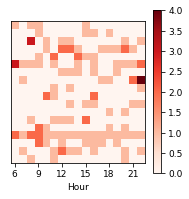

In [340]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(a_stu.groupby('hour').sum().to_numpy().T, cmap='Reds')
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
ax.get_yaxis().set_visible(False)
ax.set_xlabel("Hour");
plt.colorbar()
fig.savefig(project_dir+"figures/"+out_folder+"/after_st_outlier.png", bbox_inches='tight');

# ax.set_yticks(np.arange(len(data['stations'])))
# ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);


## Calibration

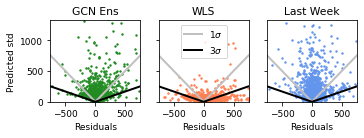

In [408]:
b_test_ens_residuals = b_y_test_eval - b_test_ens_mean
b_wls_residuals = b_y_test_eval - b_ols_pred
b_lw_residuals = b_y_test_eval - b_ref_test

fig, ax = plt.subplots(1,3,figsize=(5.5,1.5),sharey=True)
ax[0].scatter(b_test_ens_residuals, b_test_ens_std, s=2, color='forestgreen')
mi = np.percentile(b_test_ens_residuals,1)
ma = np.percentile(b_test_ens_residuals,99)
m = np.max([-mi, ma])

ax[0].plot([-m,0,m], [m,0,m], color='silver', linewidth=2)
ax[0].plot([-m,0,m], [m/3,0,m/3], color='black', linewidth=2)
ax[0].set_xlim([-m, m])
ax[0].set_ylim([0, np.percentile(b_test_ens_std,99)])
ax[0].set_xlabel("Residuals")
ax[0].set_ylabel("Predicted std")
ax[0].set_title("GCN Ens")

ax[1].scatter(b_wls_residuals, b_ols_pred_std, s=2, color='coral')
ax[1].plot([-m,0,m], [m,0,m], color='silver', linewidth=2, label=r'$1\sigma$')
ax[1].plot([-m,0,m], [m/3,0,m/3], color='black', linewidth=2, label=r'$3\sigma$')
ax[1].set_xlim([-m, m])
ax[1].set_xlabel("Residuals")
ax[1].set_title("WLS")
ax[1].legend(loc='upper center')

ax[2].scatter(b_lw_residuals, b_emp_std, s=2, color='cornflowerblue')
ax[2].plot([-m,0,m], [m,0,m], color='silver', linewidth=2)
ax[2].plot([-m,0,m], [m/3,0,m/3], color='black', linewidth=2)
ax[2].set_xlim([-m, m])
ax[2].set_xlabel("Residuals")
ax[2].set_title("Last Week")

fig.savefig(project_dir+"figures/"+out_folder+"/before_std_vs_residuals.png", bbox_inches='tight');

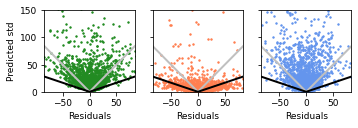

In [409]:
a_test_ens_residuals = a_y_test_eval - a_test_ens_mean
a_wls_residuals = a_y_test_eval - a_ols_pred
a_lw_residuals = a_y_test_eval - a_ref_test

fig, ax = plt.subplots(1,3,figsize=(5.5,1.5),sharey=True)
ax[0].scatter(a_test_ens_residuals, a_test_ens_std, s=2, color='forestgreen')
mi = np.percentile(a_test_ens_residuals,1)
ma = np.percentile(a_test_ens_residuals,99)
m = np.max([-mi, ma])

ax[0].plot([-m,0,m], [m,0,m], color='silver', linewidth=2)
ax[0].plot([-m,0,m], [m/3,0,m/3], color='black', linewidth=2)
ax[0].set_xlim([-m, m])
ax[0].set_ylim([0, np.percentile(a_test_ens_std,99)])
ax[0].set_xlabel("Residuals")
ax[0].set_ylabel("Predicted std")

ax[1].scatter(a_wls_residuals, a_ols_pred_std, s=2, color='coral')
ax[1].plot([-m,0,m], [m,0,m], color='silver', linewidth=2)
ax[1].plot([-m,0,m], [m/3,0,m/3], color='black', linewidth=2)
ax[1].set_xlim([-m, m])
ax[1].set_xlabel("Residuals")

ax[2].scatter(a_lw_residuals, a_emp_std, s=2, color='cornflowerblue')
ax[2].plot([-m,0,m], [m,0,m], color='silver', linewidth=2)
ax[2].plot([-m,0,m], [m/3,0,m/3], color='black', linewidth=2)
ax[2].set_xlim([-m, m])
ax[2].set_xlabel("Residuals")

fig.savefig(project_dir+"figures/"+out_folder+"/after_std_vs_residuals.png", bbox_inches='tight');

In [159]:
b_z_gcn = (b_y_test_eval - b_test_ens_mean) / b_test_ens_std
a_z_gcn = (a_y_test_eval - a_test_ens_mean) / a_test_ens_std

b_z_ols = (b_y_test_eval - b_ols_pred) / b_ols_pred_std
a_z_ols = (a_y_test_eval - a_ols_pred) / a_ols_pred_std

b_z_ref = (b_y_test_eval - b_ref_test) / b_emp_std
a_z_ref = (a_y_test_eval - a_ref_test) / a_emp_std

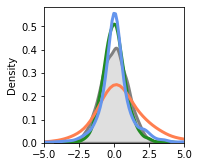

In [361]:
import seaborn as sns

fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))

sns.kdeplot(norm.rvs(size=10000, loc=0, scale=1), color='grey', fill=True, linewidth=3)
sns.kdeplot(b_z_gcn.flatten(), color='forestgreen', linewidth=3);
sns.kdeplot(b_z_ols.flatten(), color='coral', linewidth=3);
sns.kdeplot(b_z_ref.flatten(), color='cornflowerblue', linewidth=3);

ax.set_xlim([-5, 5]);


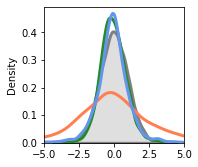

In [362]:
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5))

sns.kdeplot(norm.rvs(size=10000, loc=0, scale=1), color='grey', fill=True, linewidth=3)
sns.kdeplot(a_z_gcn.flatten(), color='forestgreen', linewidth=3);
sns.kdeplot(a_z_ols.flatten(), color='coral', linewidth=3);
sns.kdeplot(a_z_ref.flatten(), color='cornflowerblue', linewidth=3);

ax.set_xlim([-5, 5]);


## Plot \#1 : PICP vs MPIW 

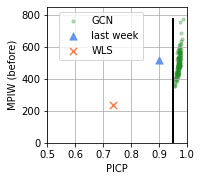

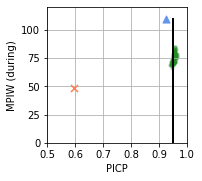

In [301]:
cmap = matplotlib.cm.get_cmap('RdYlBu')
fig, ax=plt.subplots(figsize=(2.5, 2.5))
fig2, ax2=plt.subplots(figsize=(2.5, 2.5))

ax.plot([0.95,0.95],[0,np.max(before['test_mpiw'])], color='k', linewidth=2)
ax2.plot([0.95,0.95],[0,np.max([np.max(after['test_mpiw']),bmk_after['wls_mpiw'], bmk_after['lw_mpiw']])], color='k', linewidth=2)

im1=ax.scatter(before['test_picp'], before['test_mpiw'], color='forestgreen', s=10, label='before     ', zorder = 0, alpha=0.3)
im2=ax2.scatter(after['test_picp'], after['test_mpiw'], color='forestgreen', s=10, label='during', zorder = 0, alpha=0.3)

im3=ax.scatter([bmk_before['lw_picp']], [bmk_before['lw_mpiw']], marker='^', s=50, color='cornflowerblue', label='last week', zorder = 5)
im4=ax.scatter([bmk_before['wls_picp']], [bmk_before['wls_mpiw']], marker='x', s=50, color='coral', label='WLS', zorder = 10)

im5=ax2.scatter([bmk_after['lw_picp']], [bmk_after['lw_mpiw']], marker='^', s=50, color='cornflowerblue', label='last week', zorder = 5)
im6=ax2.scatter([bmk_after['wls_picp']], [bmk_after['wls_mpiw']], marker='x', s=50, color='coral', label='WLS', zorder = 10)
'''
im7=ax.scatter([before_ens_picp], [before_ens_mpiw], marker='*', s=200, facecolors='cornflowerblue', edgecolors='blue', 
               label='GCN Ensemble', zorder = 20)
im8=ax2.scatter([after_ens_picp], [after_ens_mpiw], marker='*', s=200, facecolors='coral', edgecolors='red', 
                label='GCN Ensemble', zorder = 10)
'''
ax.set_xlabel('PICP')
ax.set_ylabel('MPIW (before)')
ax2.set_xlabel('PICP')
ax2.set_ylabel('MPIW (during)')
lg1 = ['GCN', im3.get_label(), im4.get_label()]#, im7.get_label()]
lg2 = [im1.get_label(), im2.get_label()]

ax.legend([im1, im3, im4], lg1, loc='upper left', bbox_to_anchor=(0.05,1))
# ax2.legend([im1,im2], lg2, loc='upper left', bbox_to_anchor=(0.05,0.7));
ax.set_xlim([0.55, 1])
ax2.set_xlim([0.55, 1])
ax.set_ylim([0,np.max(before['test_mpiw'])*1.1])
ax2.set_ylim([0,np.max([np.max(after['test_mpiw']),bmk_after['wls_mpiw'], bmk_after['lw_mpiw']])*1.1])

ax.set_xticks(np.arange(0.5, 1.05, 0.1))
ax2.set_xticks(np.arange(0.5, 1.05, 0.1))
ax.grid()
ax2.grid()

fig.savefig(project_dir+"figures/"+out_folder+"/before_picp_mpiw_tradeoff.png", bbox_inches='tight');
fig2.savefig(project_dir+"figures/"+out_folder+"/after_picp_mpiw_tradeoff.png", bbox_inches='tight');


## Plot \#2 : NLL vs. MAPE vs. MPIW

In [161]:
from sklearn.linear_model import LinearRegression
X = before['test_picp'].to_numpy().reshape((-1,1))
y = before['test_mpiw'].to_numpy()
reg_before = LinearRegression().fit(X,y)
mpiw_95 = reg_before.predict(np.array(0.95).reshape(1,1))
before['test_mpiw_lr'] = reg_before.predict(X)
before['test_nmpiw'] = before['test_mpiw'] / before['test_mpiw_lr'] * mpiw_95
print('MPIW = %.2f PICP + %.2f' % (reg_before.coef_[0],reg_before.intercept_))

MPIW = 9582.56 PICP + -8796.61


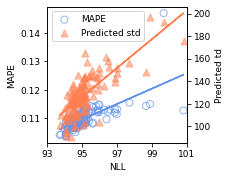

In [421]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
filt = before['test_picp']>0.95
ln1 = ax.scatter(before[filt]['test_nll_loss'], before[filt]['test_mape'], marker='o', s=50, 
                 edgecolors='cornflowerblue', facecolors='none', label='MAPE', alpha=0.7, zorder=1)
m, b = np.polyfit(before[filt]['test_nll_loss'], before[filt]['test_mape'], 1)
ax.plot(before[filt]['test_nll_loss'], m*before[filt]['test_nll_loss'] + b, color='cornflowerblue')

ax2 = ax.twinx()
ln2 = ax2.scatter(before[filt]['test_nll_loss'],before[filt]['test_mpiw']/3.92, marker='^', s=50,
                  color='coral', label='Predicted std', alpha=0.5, zorder=1)
m, b = np.polyfit(before[filt]['test_nll_loss'], before[filt]['test_mpiw']/3.92, 1)
ax2.plot(before[filt]['test_nll_loss'], m*before[filt]['test_nll_loss'] + b, color='coral')

'''
pt1 = ax.scatter([before_ens_nll], [before_ens_u], marker='o', s=125, facecolors='cornflowerblue', edgecolors='blue', 
               label='GCN Ensemble', zorder = 3)
pt2 = ax2.scatter([before_ens_nll], [before_ens_mpiw], marker='^', s=125, facecolors='coral', edgecolors='red', 
                label='GCN Ensemble', zorder = 3)
'''
ax.set_xlabel('NLL')
ax.set_ylabel('MAPE')
ax2.set_ylabel("Predicted td")
lg = [ln1.get_label(), ln2.get_label()]#, pt1.get_label(), pt2.get_label()]
ax.legend([ln1, ln2], lg, loc=2)
ax.set_xlim([before['test_nll_loss'].min(), before['test_nll_loss'].max()])
ax.set_xticks(np.arange(before['test_nll_loss'].astype(int).min(), before['test_nll_loss'].max()+1,2))
ax.grid()
fig.savefig(project_dir+"figures/"+out_folder+"/before_nll_mape_std_tradeoff.png", bbox_inches='tight');


In [413]:
X = after['test_picp'].to_numpy().reshape((-1,1))
y = after['test_mpiw'].to_numpy()
reg_after = LinearRegression().fit(X,y)
mpiw_95 = reg_after.predict(np.array(0.95).reshape(1,1))
after['test_mpiw_lr'] = reg_after.predict(X)
after['test_nmpiw'] = after['test_mpiw'] / after['test_mpiw_lr'] * mpiw_95
print('MPIW = %.2f PICP + %.2f' % (reg_after.coef_[0],reg_after.intercept_))

NameError: name 'LinearRegression' is not defined

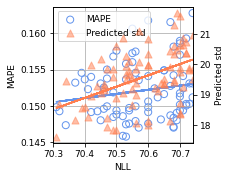

In [422]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
filt = after['test_picp']>0.95
ln1 = ax.scatter(after[filt]['test_nll_loss'],after[filt]['test_mape'], marker='o', s=50,
                 edgecolors='cornflowerblue', facecolors='none', label='MAPE')
m, b = np.polyfit(after[filt]['test_nll_loss'], after[filt]['test_mape'], 1)
ax.plot(after[filt]['test_nll_loss'], m*after[filt]['test_nll_loss'] + b, color='cornflowerblue')

ax2 = ax.twinx()
ln2 = ax2.scatter(after[filt]['test_nll_loss'], after[filt]['test_mpiw']/3.92, marker='^', s=50, 
                  color='coral', alpha=0.5, label='Predicted std')
m, b = np.polyfit(after[filt]['test_nll_loss'], after[filt]['test_mpiw']/3.92, 1)
ax2.plot(after[filt]['test_nll_loss'], m*after[filt]['test_nll_loss'] + b, color='coral')

'''
pt1 = ax.scatter([after_ens_nll], [after_ens_u], marker='o', s=125, facecolors='cornflowerblue', edgecolors='blue', 
               label='GCN Ensemble', zorder = 3)
pt2 = ax2.scatter([after_ens_nll], [after_ens_mpiw], marker='^', s=125, facecolors='coral', edgecolors='red', 
                label='GCN Ensemble', zorder = 3)
'''
ax.set_xlabel('NLL')
ax.set_ylabel('MAPE')
ax2.set_ylabel("Predicted std")
lg = [ln1.get_label(), ln2.get_label()]#, pt1.get_label(), pt2.get_label()]
ax.legend([ln1, ln2], lg, loc=2);
ax.set_xlim([after[filt]['test_nll_loss'].min(),after[filt]['test_nll_loss'].max()])
ax.set_xticks(np.arange(after[filt]['test_nll_loss'].round(1).min(), after[filt]['test_nll_loss'].max(),0.1))

ax.grid()
fig.savefig(project_dir+"figures/"+out_folder+"/after_nll_mape_std_tradeoff.png", bbox_inches='tight');


## Plot \#3: Average Cell Flow vs. MPIW

In [293]:
def flow_vs_pi(period, test_ens_mean, test_ens_std, y_test_eval, legend=True):
    picp_list = []
    mpiw_list = []
    avg_flow_list = []
    nmpiw_list = []
    for i in range(test_ens_mean.shape[1]):
        mpiw, picp = util_eval.eval_pi(test_ens_mean[:, i] - z*test_ens_std[:, i], 
                            test_ens_mean[:, i] + z*test_ens_std[:, i], 
                            y_test_eval[:, i])
        picp_list.append(picp)
        mpiw_list.append(mpiw)
        avg_flow_list.append(np.mean(test_ens_mean[:, i,]))
        nmpiw_list.append(mpiw/np.mean(test_ens_mean[:, i]))

    avg_flow_list = np.array(avg_flow_list)
    nmpiw_list = np.array(nmpiw_list)
    
    fig, ax = plt.subplots(figsize=(2.5,2.5))
    axt = ax.twinx()
    s1 = axt.scatter(avg_flow_list, nmpiw_list, color='coral', s=30, alpha=0.8, label='MPIW/Demand')
    s2 = ax.scatter(avg_flow_list, mpiw_list, color='cornflowerblue', s=30, alpha=0.8, label='MPIW')
    
    m,b = np.polyfit(avg_flow_list, np.log(nmpiw_list), 1)
    x = np.arange(avg_flow_list.min()*0.95, avg_flow_list.max()*1.05)
    axt.plot(x, np.exp(m*x+b), color='coral')
    
    m, b= np.polyfit(avg_flow_list, mpiw_list, 1)
    ax.plot(avg_flow_list, m*avg_flow_list+b, color='cornflowerblue')

    ax.set_xlabel('Average Travel Demand')
    ax.set_ylabel('MPIW')
    axt.set_ylabel('MPIW/Demand')
    if legend:
        ax.legend([s1,s2], [s1.get_label(), s2.get_label()], loc=2)
    ax.grid()
    tick_space = ((max(avg_flow_list) - min(avg_flow_list)) / 3) // 10 * 10
    ax.set_xticks(np.arange(min(avg_flow_list)//10*10, max(avg_flow_list), tick_space))
    fig.savefig(project_dir+"figures/"+out_folder+"/"+period+"_flow_vs_mpiw.png", bbox_inches='tight')
    
#     fig, ax = plt.subplots(figsize=(2.5,2.5))
#     ax.scatter(avg_flow_list, picp_list, color='royalblue', s=30, alpha=0.8)
#     ax.set_xlabel('Average Travel Demand')
#     ax.set_ylabel('PICP');
#     ax.set_xticks(np.arange(min(avg_flow_list)//10*10, max(avg_flow_list), tick_space))
#     ax.grid()
#     fig.savefig(project_dir+"figures/"+out_folder+"/"+period+"_flow_vs_picp.png", bbox_inches='tight')
    

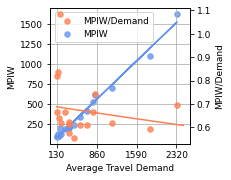

In [294]:
flow_vs_pi('before', b_test_ens_mean,  b_test_ens_std, b_y_test_eval);

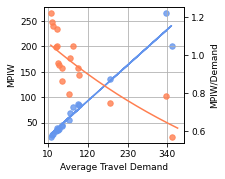

In [295]:
flow_vs_pi('after', a_test_ens_mean,  a_test_ens_std, a_y_test_eval, legend=False)